In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pickle
import os, sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

HOME = Path(os.getcwd()).parents[0]

sys.path.insert(1, str(HOME))
log_folder = '/user/home/uz22147/logs/cgan/38fba564f1c9852b/n1000_201806-201905_e50'

from dsrnngan.plots import plot_precip


In [3]:
eval_df = pd.read_csv(os.path.join(log_folder, 'eval_validation.csv'))
eval_df.head()

,N,op,CRPS_no_pooling,CRPS_max_4,CRPS_max_16,CRPS_avg_4,CRPS_avg_16,mae,rmse,emmse,emmse_fcst,ralsd,corr,corr_ensemble,corr_fcst
0,160000,0.077346,0.12136,0.12136,0.12136,0.12136,0.12136,0.199353,0.870995,0.572712,0.570935,3.551033,0.071014,0.044637,0.021691


In [4]:
with np.load(os.path.join(log_folder, 'ranks-160000.npz')) as ranks_data:
    ranks_dict = dict(ranks_data.items())

with open(os.path.join(log_folder, 'other_metrics-160000.pkl'), 'rb') as ifh:
    other_metrics = pickle.load(ifh)

with open(os.path.join(log_folder, 'arrays-160000.pkl'), 'rb') as ifh:
    arrays = pickle.load(ifh)

In [64]:
truth_array = arrays['truth']
samples_gen_array = arrays['samples_gen']
fcst_array = arrays['fcst_array']
dates = arrays['dates']
hours = arrays['hours']

In [65]:
dates

array([datetime.date(2018, 7, 26)], dtype=object)

 20%|██        | 1/5 [00:00<00:01,  2.37it/s]


IndexError: index 1 is out of bounds for axis 0 with size 1

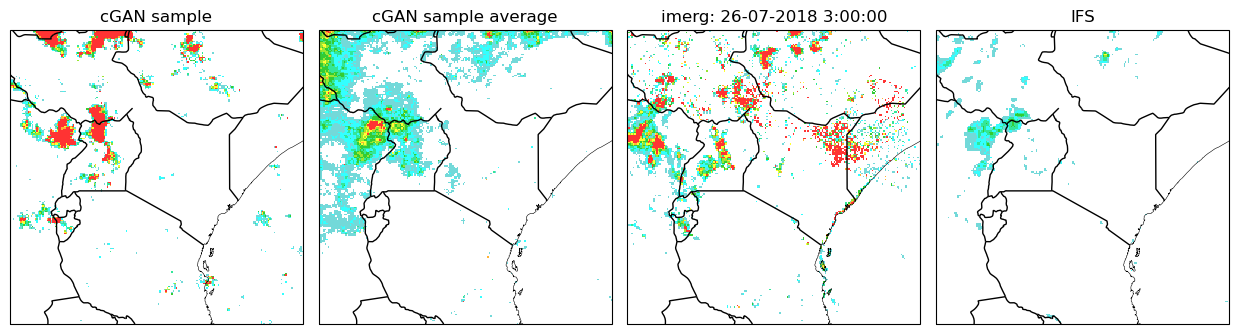

In [61]:
import os
import pickle
from tqdm import tqdm
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib as mpl
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import colorbar, colors, gridspec
from metpy import plots as metpy_plots
from dsrnngan import data
from dsrnngan.noise import NoiseGenerator
from dsrnngan.rapsd import plot_spectrum1d, rapsd
from dsrnngan.thresholded_ranks import findthresh
from dsrnngan.plots import plot_precip
import copy
from matplotlib.colors import ListedColormap, BoundaryNorm

tp_index = data.all_ifs_fields.index('tp')

# plot configurations

spacing = 10
units = "Rain rate [mm h$^{-1}$]"
precip_levels=np.arange(0, 1.5, 0.15)
num_samples = 5
num_rows = num_samples
num_cols = 5

# , figsize = (num_rows*4, num_cols*4)),
# gs = gridspec.GridSpec(spacing*num_rows+1, spacing*num_cols, wspace=0.5, hspace=2)
rows = [[f'cgan_sample_{n}', f'cgan_mean_{n}', f'imerg_{n}', f'ifs_{n}', 'cbar'] for n in range(num_rows)]

fig = plt.figure(constrained_layout=True, figsize=(2.5*num_cols, 3*num_rows))
gs = gridspec.GridSpec(num_rows, num_cols, figure=fig, width_ratios=[1]*(num_cols - 1) + [0.05],
                       wspace=0.01)                      
for n in tqdm(range(num_samples)):

    img_gens = samples_gen_array[n, :,:,:]
    truth = truth_array[n,:,:]
    fcst = fcst_array[n,:,:]
    date = dates[n]
    hour = hours[n]
    avg_img_gens = img_gens.mean(axis=-1)
    date_str = date.strftime('%d-%m-%Y') + f' {hour}:00:00'
    
    # cGAN
    data_lookup = {'cgan_sample': {'data': img_gens[:,:,0], 'title': 'cGAN sample'},
                   'cgan_mean': {'data': avg_img_gens, 'title': f'cGAN sample average'},
                   'imerg' : {'title': f"imerg: {date_str}", 'data': truth},
                   'ifs': {'data': fcst, 'title': 'IFS'}
                   }
    for col, (k, val) in enumerate(data_lookup.items()):
   
        ax = fig.add_subplot(gs[n, col], projection = ccrs.PlateCarree())
        im = plot_precip(np_array=val['data'], ax=ax, levels=precip_levels)
        ax.set_title(val['title'])
        
precip_cmap = ListedColormap(metpy_plots.ctables.colortables["precipitation"][:len(precip_levels)-1], 'precipitation')
precip_norm = BoundaryNorm(precip_levels, precip_cmap.N)
cbar_ax = fig.add_subplot(gs[1:-1 ,-1])
# cb = mpl.colorbar.Colorbar(axd['cbar'], cmap=precip_cmap, norm=precip_norm)
# cbar_ax = fig.add_axes([0.95, 0.0, 0.02, 0.95])
cb = fig.colorbar(im, cax=cbar_ax, orientation='vertical', shrink = 0.2, aspect=20)

# cb.ax.set_yticks(precip_levels)
# cb.ax.set_yticklabels(precip_levels)
# cb.ax.tick_params(axis='both', which='major')
cb.ax.set_ylabel("Precipitation (mm / hr)")
plt.savefig('cGAN_samples_IFS.png', dpi=fig.dpi)

In [62]:
dates

array([datetime.date(2018, 7, 26)], dtype=object)

In [6]:
other_metrics.keys()
quantiles = other_metrics['quantiles']
rapsd_dict = {k: v for k, v in other_metrics.items() if k.startswith('rapsd')}
bias_dict = {k: v for k, v in other_metrics.items() if k.startswith('bias')}
crps_dict = {k: v for k, v in other_metrics.items() if k.startswith('CRPS')}

In [48]:
from dsrnngan.data import DEFAULT_LATITUDE_RANGE, DEFAULT_LONGITUDE_RANGE

special_areas = {'lake_victoria': {'lat_range': [-3,1], 'lon_range': [31, 35]},
                 'nairobi': {'lat_range': [-1.5,-1], 'lon_range': [36.5, 37]},
                 'mombasa (coastal)': {'lat_range': [-4.1,-3.9], 'lon_range': [39.5, 39.8]},
                 'addis ababa': {'lat_range': [8.8, 9.1], 'lon_range': [38.5, 38.9]},
                 'bale_mountains': {'lat_range': [6.6, 7.0], 'lon_range': [39.3, 40.2]}}

lat_range = [np.round(item, 1) for item in DEFAULT_LATITUDE_RANGE]
lon_range = [np.round(item, 1) for item in DEFAULT_LONGITUDE_RANGE]

for k, v in special_areas.items():
    special_areas[k]['lat_index_range'] = [lat_range.index(v['lat_range'][0]), lat_range.index(v['lat_range'][1])]
    special_areas[k]['lon_index_range'] = [lon_range.index(v['lon_range'][0]), lon_range.index(v['lon_range'][1])]

## Rank histogram

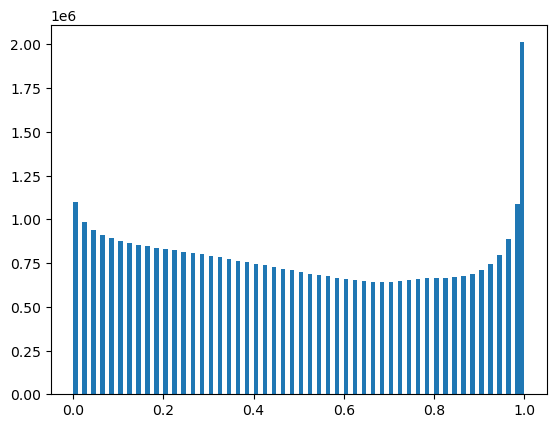

In [7]:
plt.hist(ranks_dict['ranks'], bins=100)
plt.show()

# RAPSD

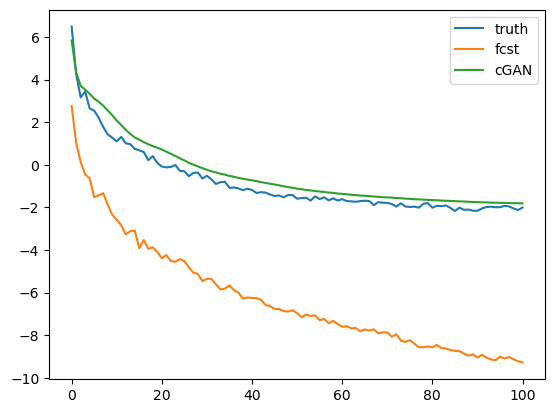

In [8]:
fig, ax = plt.subplots(1,1)

ax.plot(np.log(rapsd_dict['rapsd_truth']), label='truth')
ax.plot(np.log(rapsd_dict['rapsd_fcst']), label='fcst')
ax.plot(np.log(rapsd_dict['rapsd_pred']), label='cGAN') # Single member of ensemble
ax.legend()

## Quantiles

In [56]:
quantile_boundaries = np.arange(0, 1, 1/20)
truth_quantiles = np.quantile(truth_array, quantile_boundaries)
sample_quantiles = np.quantile(samples_gen_array[:,:,:, 0], quantile_boundaries)
fcst_quantiles = np.quantile(fcst_array, quantile_boundaries)

Text(0.5, 0, 'model')

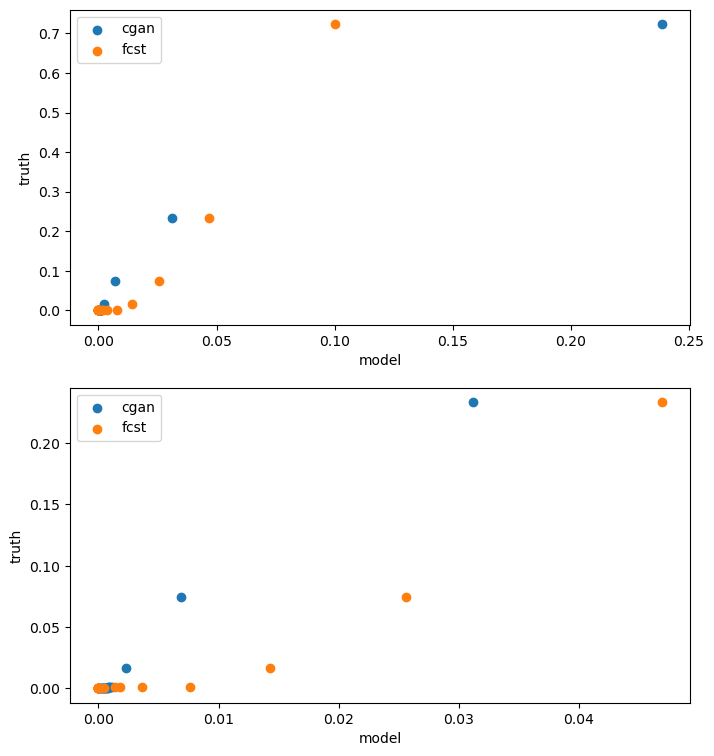

In [57]:
fig, ax = plt.subplots(2,1, figsize=(8, 9))

ax[0].scatter(sample_quantiles, truth_quantiles, label='cgan')
ax[0].scatter(fcst_quantiles, truth_quantiles, label='fcst')
ax[0].set_ylabel('truth')
ax[0].set_xlabel('model')
ax[0].legend()

ax[1].scatter(sample_quantiles[:-1], truth_quantiles[:-1], label='cgan')
ax[1].scatter(fcst_quantiles[:-1], truth_quantiles[:-1], label='fcst')
ax[1].legend()
ax[1].set_ylabel('truth')
ax[1].set_xlabel('model')

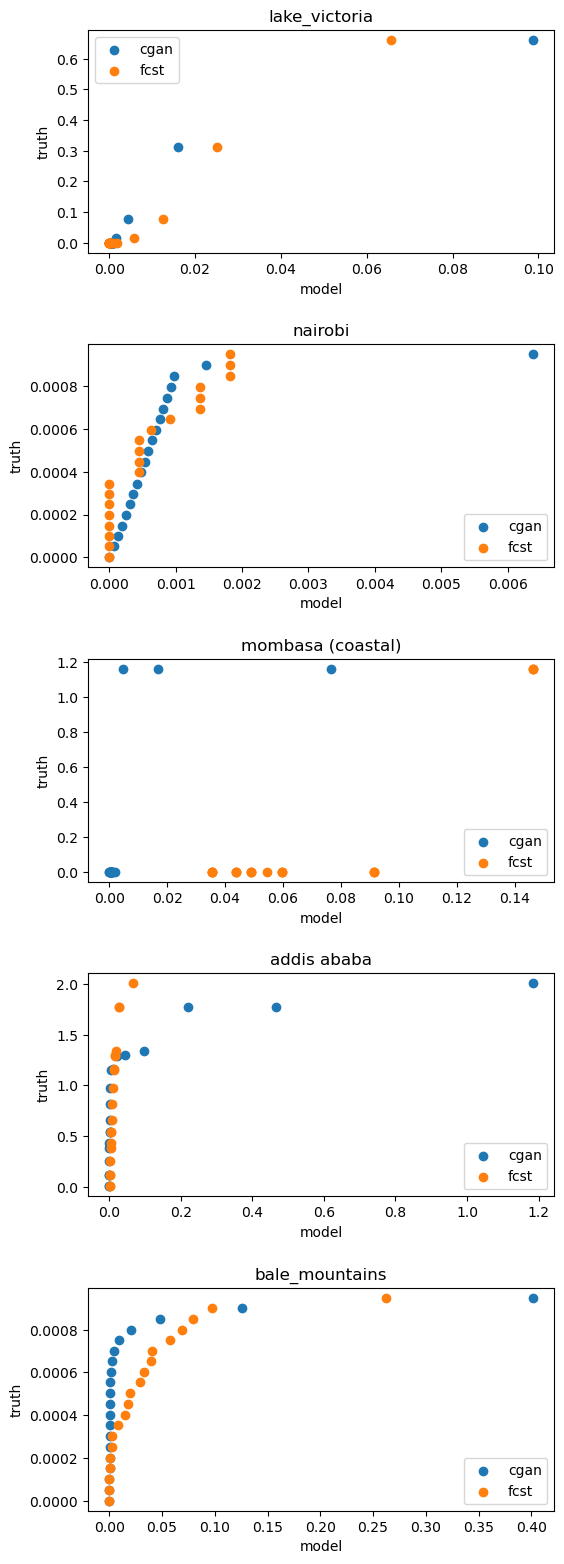

In [49]:
# Quantiles for different areas
quantile_boundaries = np.arange(0, 1, 1/20)

fig, ax = plt.subplots(max(2, len(special_areas)),1, figsize=(6, 16))

for n, (area, area_range) in enumerate(special_areas.items()):


    lat_range = area_range['lat_index_range']
    lon_range = area_range['lon_index_range']
    truth_quantiles = np.quantile(truth_array[:, lat_range[0]:lat_range[1], lon_range[0]:lon_range[1]], quantile_boundaries)
    sample_quantiles = np.quantile(samples_gen_array[:, lat_range[0]:lat_range[1], lon_range[0]:lon_range[1], 0], quantile_boundaries)
    fcst_quantiles = np.quantile(fcst_array[:, lat_range[0]:lat_range[1], lon_range[0]:lon_range[1]], quantile_boundaries)
    
    ax[n].scatter(sample_quantiles, truth_quantiles, label='cgan')
    ax[n].scatter(fcst_quantiles, truth_quantiles, label='fcst')
    ax[n].set_ylabel('truth')
    ax[n].set_xlabel('model')
    ax[n].set_title(area)
    ax[n].legend()
    
fig.tight_layout(pad=2.0)
plt.show()

## Grid metrics

In [10]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from matplotlib import colorbar, colors, gridspec
from dsrnngan.plots import default_latitude_range, default_longitude_range


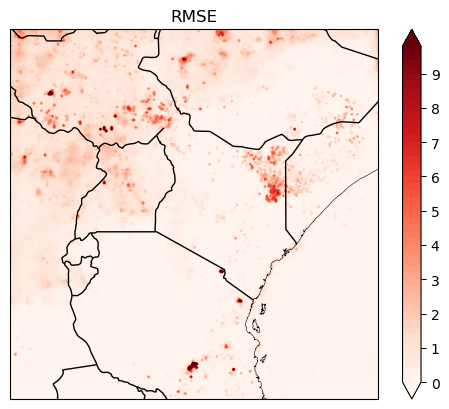

In [19]:
# RMSE
fig, ax = plt.subplots(1, 1, 
                       subplot_kw={'projection' : ccrs.PlateCarree()})

max_level = 10
value_range = list(np.arange(0, max_level, max_level / 50))

im = ax.contourf(default_longitude_range, default_latitude_range, other_metrics['rmse'], transform=ccrs.PlateCarree(),
                    cmap='Reds', 
                    levels=value_range, norm=colors.Normalize(min(value_range), max(value_range)),
                    extend='both')

ax.coastlines(resolution='10m', color='black', linewidth=0.4)
ax.add_feature(cfeature.BORDERS)
ax.set_title('RMSE')
plt.colorbar(im, ax=ax)

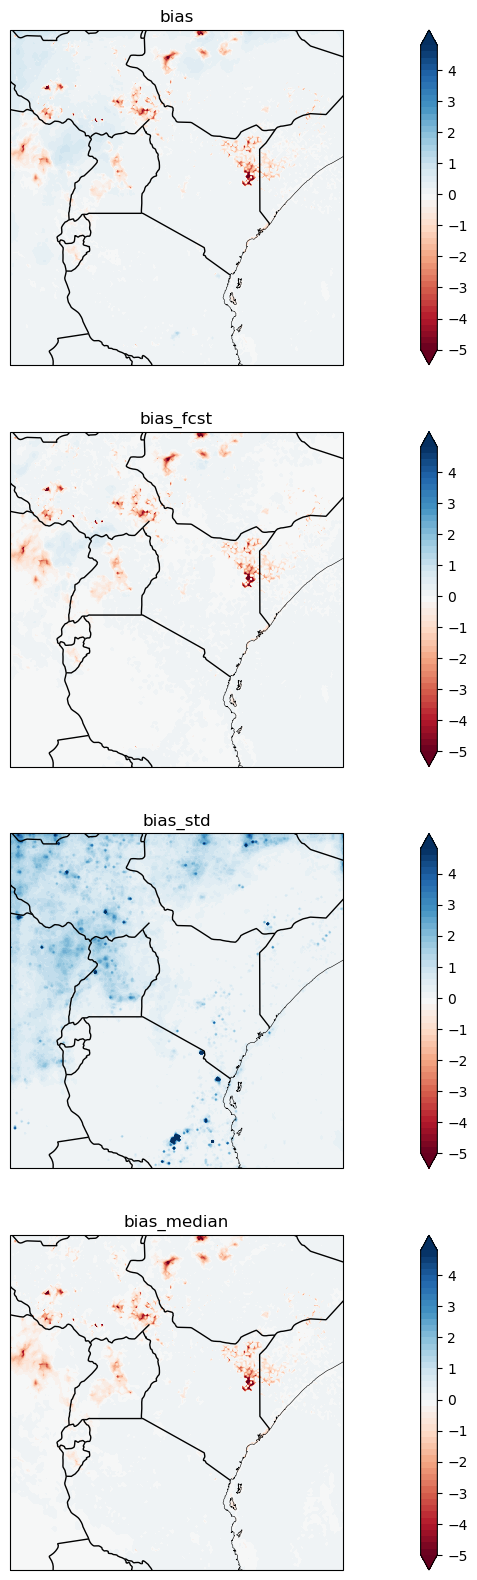

In [23]:


fig, ax = plt.subplots(len(bias_dict.keys()), 1, 
                       subplot_kw={'projection' : ccrs.PlateCarree()}, figsize=(20, 20))

for n, k in enumerate(bias_dict.keys()):

    if k != 'bias_std':
        max_level = 5
        value_range = list(np.arange(-max_level, max_level, 2*max_level / 50))
    else:
        max_level = 5
        value_range = list(np.arange(-max_level, max_level, 2*max_level / 50))

    im = ax[n].contourf(default_longitude_range, default_latitude_range, bias_dict[k], transform=ccrs.PlateCarree(),
                        cmap='RdBu', 
                        levels=value_range, norm=colors.Normalize(min(value_range), max(value_range)),
                        extend='both')

    ax[n].coastlines(resolution='10m', color='black', linewidth=0.4)
    ax[n].add_feature(cfeature.BORDERS)
    ax[n].set_title(k)
    plt.colorbar(im, ax=ax[n])

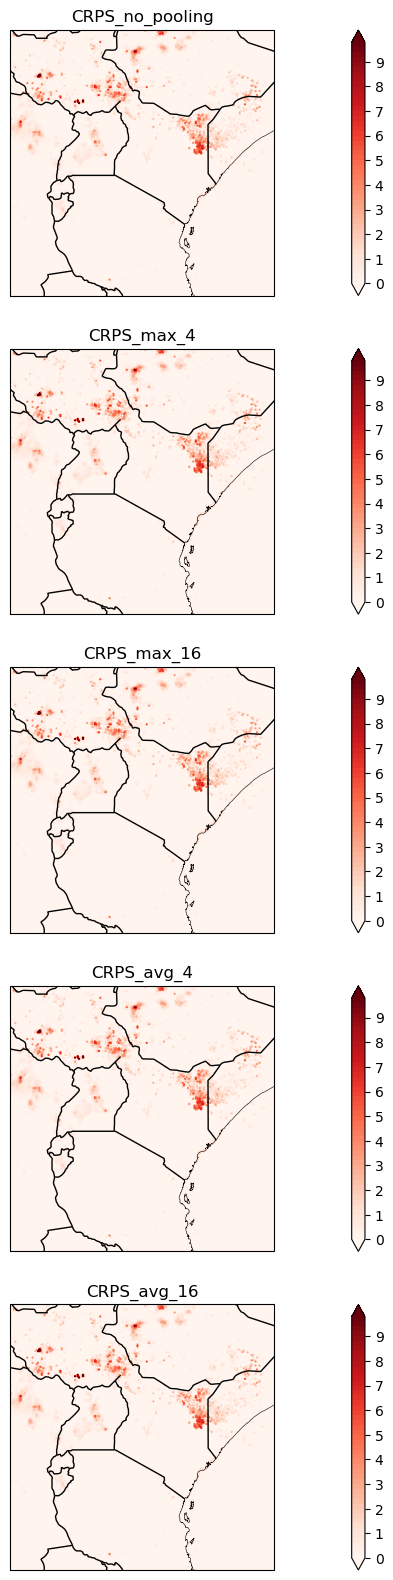

In [26]:
fig, ax = plt.subplots(len(crps_dict.keys()), 1, 
                       subplot_kw={'projection' : ccrs.PlateCarree()}, figsize=(20, 20))

for n, k in enumerate(crps_dict.keys()):

    max_level = 10
    value_range = list(np.arange(0, max_level, max_level / 50))

    im = ax[n].contourf(default_longitude_range, default_latitude_range, crps_dict[k], transform=ccrs.PlateCarree(),
                        cmap='Reds', 
                        levels=value_range, norm=colors.Normalize(min(value_range), max(value_range)),
                        extend='both')

    ax[n].coastlines(resolution='10m', color='black', linewidth=0.4)
    ax[n].add_feature(cfeature.BORDERS)
    ax[n].set_title(k)
    plt.colorbar(im, ax=ax[n])

## Scatter plots

In [27]:
import random

truth = arrays['truth']
samples_gen = arrays['samples_gen']

(num_images, height, width, ensemble_size) = samples_gen.shape

stacked_truth = np.repeat(truth[:, :, :, np.newaxis], ensemble_size, axis=3)

In [28]:
indexes = random.sample(range(len(samples_gen.flatten())), 10000)

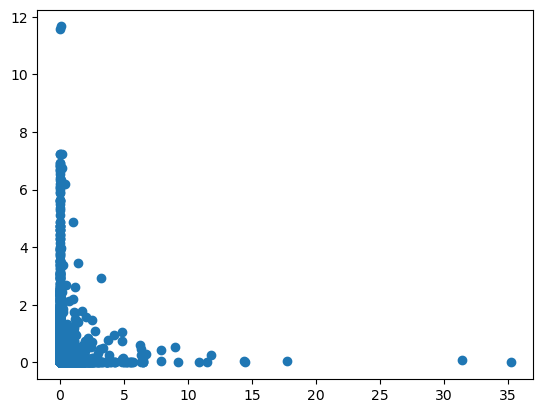

In [29]:
plt.scatter(samples_gen.flatten()[indexes], stacked_truth.flatten()[indexes])

# Fractional skill score

In [34]:
from dsrnngan.scoring import fss
from tqdm import tqdm

truth = arrays['truth']
samples_gen = arrays['samples_gen'][:,:,:,0] # Only taking a single ensemble member
fcst_array = arrays['fcst_array']
window_sizes = range(1,200)
thr = 0.01

fss_cgan = []
fss_fcst = []
for w in tqdm(window_sizes):
    
    fss_cgan.append(fss(truth, samples_gen, w, thr, mode='constant') )
    fss_fcst.append(fss(truth, fcst_array, w, thr, mode='constant') )

100%|██████████| 199/199 [09:23<00:00,  2.83s/it]


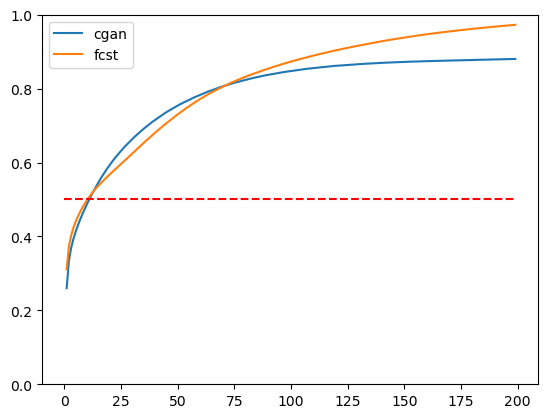

In [39]:
fig, ax = plt.subplots(1, 1)

ax.plot(window_sizes, [item[0] for item in fss_cgan], label='cgan')
ax.plot(window_sizes, [item[0] for item in fss_fcst], label='fcst')
ax.hlines(0.5, 0, max(window_sizes), linestyles='dashed', colors=['r'])
ax.set_ylim(0,1)
ax.legend()

